# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: *** YOUR ID HERE ***

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

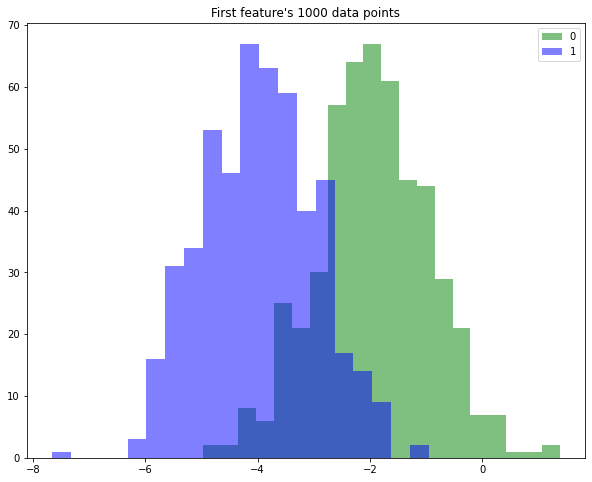

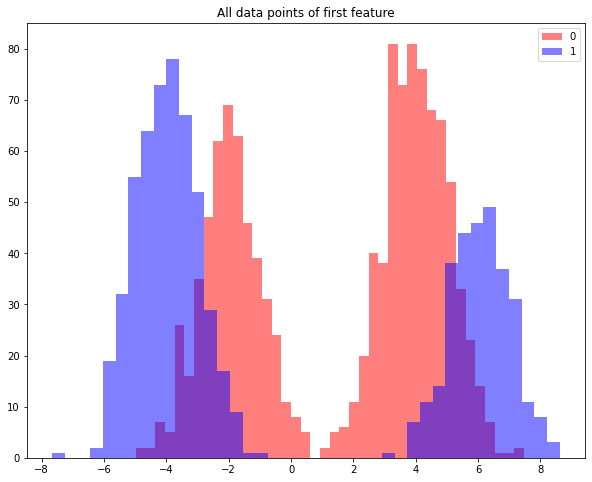

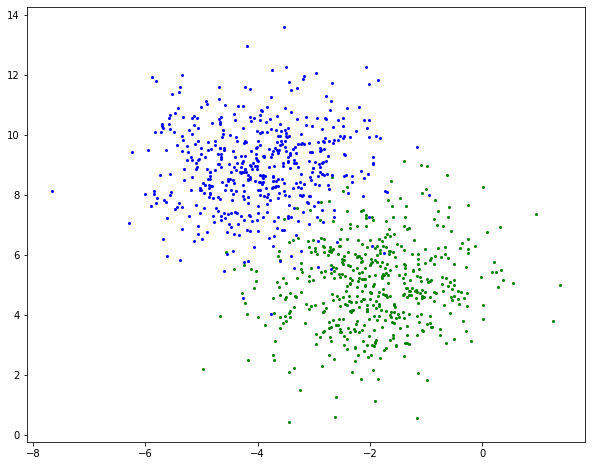

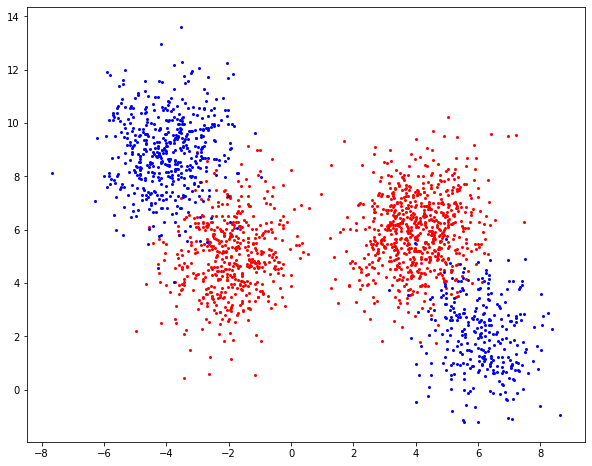

In [4]:
data_points_number = 1000
first_histo_num_of_bins = 20
histo_alpha = 0.5
second_histo_num_of_bins = 40
X1_data_points = training_set[['x1', 'y']].values
X2_data_points = training_set[['x2', 'y']].values
first_histo_data_points=training_set.head(data_points_number)
X1_1000_data_points = first_histo_data_points[['x1', 'y']].values
X2_1000_data_points = first_histo_data_points[['x2','y']].values

plt.hist([X1_1000_data_points[X1_1000_data_points[:,-1]==0][:,0]], first_histo_num_of_bins, facecolor='green', alpha = histo_alpha, label = 0)
plt.hist([X1_1000_data_points[X1_1000_data_points[:,-1]==1][:,0]], first_histo_num_of_bins, facecolor='blue', alpha = histo_alpha, label = 1)
plt.legend()
plt.title("First feature's 1000 data points")
plt.show()

plt.hist([X1_data_points[X1_data_points[:,-1]==0][:,0]], second_histo_num_of_bins, facecolor='red', alpha = histo_alpha, label = 0)
plt.hist([X1_data_points[X1_data_points[:,-1]==1][:,0]], second_histo_num_of_bins, facecolor='blue', alpha = histo_alpha, label = 1)
plt.legend()
plt.title("All data points of first feature")
plt.show()

plt.scatter([X1_1000_data_points[X1_1000_data_points[:,-1]==0][:,0]],[X2_1000_data_points[X2_1000_data_points[:,-1]==0][:,0]], color = 'green',s = 4)
plt.scatter([X1_1000_data_points[X1_1000_data_points[:,-1]==1][:,0]],[X2_1000_data_points[X2_1000_data_points[:,-1]==1][:,0]], color = 'blue',s = 4)
plt.show()

plt.scatter([X1_data_points[X1_data_points[:,-1]==0][:,0]],[X2_data_points[X2_data_points[:,-1]==0][:,0]], color = 'red',s = 4)
plt.scatter([X1_data_points[X1_data_points[:,-1]==1][:,0]],[X2_data_points[X2_data_points[:,-1]==1][:,0]], color = 'blue',s = 4)
plt.show()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [5]:
#Bias
ones_col = np.ones(len(X_training[:,0]))
X_training_bias = np.column_stack((ones_col, X_training))
test_X_value__ones = np.ones(len(X_test[:,0]))
X_test_bias = np.column_stack((test_X_value__ones, X_test))

In [6]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.theta = None;
        self.cost_history = []
        self.random_state = random_state
        np.random.seed(self.random_state)
                
    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        self.theta = np.random.random(size = len(X[0,:]))
        self.cost_history.append(self.compute_cost(X,y))
        self.gradient_descent(X, y)


    def compute_cost(self,X, y):
        m = len(y)
        cost = (1/m)*((np.matmul((-y).T, np.log(self.hypo_Func(X)))) - (np.matmul((1-y).T, np.log(1 - self.hypo_Func(X)))))
        return cost
    
    def hypo_Func(self, X):
        power = (-1) * np.matmul(X, self.theta)
        wanted_val = 1/(1+np.exp(power))
        return wanted_val
                       
    def gradient_descent(self, X, y):
        for i in range(1,self.n_iter):
            self.theta = self.theta - (self.eta * (np.matmul(X.T, (self.hypo_Func(X) - y)))) 
            self.cost_history.append(self.compute_cost(X, y))
            if ((len(self.cost_history) > 1) and (np.abs(self.cost_history[-2] - self.cost_history[-1]) < self.eps)):
                break

                       
    def predict(self, X):
        if((len(X[0,:])!=(len(self.theta)))):
            ones_col = np.ones(len(X[:,0]))
            wanted_X = np.column_stack((ones_col, X))
            return np.rint(self.hypo_Func(wanted_X)) 
                                              
        return np.rint(self.hypo_Func(X))  
                
    def get_accuracy(self,X,y):
        m = len(y)
        sum_of_predictions = 0.0
        prediction = self.predict(X)
        for i in range(0,m):
            if prediction[i]==y[i]:
                sum_of_predictions = sum_of_predictions + 1
        return sum_of_predictions / m  


## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [ ]:
#Shuffle the training set 
np.random.seed(1)
etas = [ 0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
fold_size = 5
possible_combos_pre = np.array(np.meshgrid(etas, epss))
all_possible_combos = possible_combos_pre.T.reshape(-1, 2)
X_y_training=np.column_stack((X_training_bias, y_training))
np.take(X_y_training, np.random.permutation(X_y_training.shape[0]), axis = 0, out = X_y_training)

#Start spliting
best_parmaters = None
most_accurate = None
wanted_X_training_bias=X_y_training[:, 0:-1]
wanted_y_training_bias=X_y_training[:,-1]
fold_to_Cross = int(len(X_training[:,0]) / fold_size)

# Iterate through all the possible combinations
for combo in all_possible_combos:
    start = 0
    combos_accuracy=0
    logistic_reg = LogisticRegressionGD(combo[0],10000,combo[1])
    
    # Split
    for i in range(0,fold_size - 1):
        CV_x = wanted_X_training_bias[start:(start + fold_to_Cross),:]
        CV_y = wanted_y_training_bias[start:(start + fold_to_Cross)]
        modified_x_train = np.concatenate((wanted_X_training_bias[:start,:],
                                           wanted_X_training_bias[(start + fold_to_Cross):,:]), axis=0)
        modified_y_train = np.concatenate((wanted_y_training_bias[:start], 
                                           wanted_y_training_bias[(start + fold_to_Cross):]), axis = 0)
        start += fold_to_Cross
        logistic_reg.fit(modified_x_train,modified_y_train)
        accuracy = logistic_reg.get_accuracy(CV_x,CV_y)
        combos_accuracy = combos_accuracy + accuracy    
        
    CV_x = wanted_X_training_bias[start:,:]
    CV_y = wanted_y_training_bias[start:]
    modified_x_train = wanted_X_training_bias[:start,:]
    modified_y_train = wanted_y_training_bias[:start]    
    logistic_reg.fit(modified_x_train,modified_y_train)
    accuracy = logistic_reg.get_accuracy(CV_x,CV_y)
    combos_accuracy = combos_accuracy + accuracy
    combos_accuracy = combos_accuracy / fold_size
    if best_parmaters is None:
        best_parmaters = combo
        most_accurate = combos_accuracy
    elif most_accurate < combos_accuracy:
        best_parmaters = combo
        most_accurate = combos_accuracy
        
print("Best eps and eta params are: " + str(best_parmaters))

## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [ ]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    fraction = 1 / (sigma * np.sqrt(2*np.pi))
    inner_power_expression = (data - mu)/sigma 
    whole_power_expression = (-1/2)*(inner_power_expression**2)
    exponent = np.exp(whole_power_expression)
    formula = fraction * exponent
    return formula

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [ ]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.mu_arr = None
        self.w_arr = None 
        self.sigma_arr = None
        self.resp = None

        
    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        sorted_data = np.sort(data)
        self.resp = np.zeros(shape=(len(data[:]),self.k))
        self.resp=self.resp.astype(np.float)
        self.sigma_arr = (np.zeros(self.k)).astype(np.float)
        self.w_arr = (np.zeros(self.k)).astype(np.float)
        self.mu_arr = (np.zeros(self.k)).astype(np.float)
        np.random.seed(42)
        cross_fold =(int)((len(data[:])) / self.k)
        sorted_data=np.sort(data[:])
        start = 0
        for i in range(0,self.k):
            if i == self.k - 1:
                k_of_x = sorted_data[start:]
            else:
                k_of_x = sorted_data[start:(start + cross_fold)]
            start += cross_fold
            self.mu_arr[i] = k_of_x.mean()
            self.sigma_arr[i] = ((np.sum((k_of_x[:] - self.mu_arr[i])**2))/(len(k_of_x[:])))**(1/2)   
            self.w_arr[i] = 1.0 / self.k
       
        
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        for ind in range (len(data[:])):
            for k in range (self.k):
                self.resp[ind, k] = self.w_arr[k] * norm_pdf(data[ind],self.mu_arr[k], self.sigma_arr[k]) 
            self.resp[ind] = self.resp[ind] / np.sum(self.resp[ind])


    def maximization(self, data):
        """
        M step - updating distribution params
        """
        num_rows = (1 / len(data[:]))
        weights_to_be_in = num_rows * np.sum(self.resp, axis=0)
        for k in range(self.k):
            self.w_arr[k] = weights_to_be_in[k]
            sum_to_be_inserted = np.sum((self.resp[:,k] * data))
            self.mu_arr[k] = (num_rows / self.w_arr[k]) * sum_to_be_inserted
            sum_to_be_inserted = np.sum((self.resp[:,k] * (data-self.mu_arr[k])**2))
            self.sigma_arr[k] = np.sqrt((num_rows / self.w_arr[k]) * sum_to_be_inserted)
                                      

    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        new_cost_func = 0.0
        old_cost_func = None
        for i in range(0,self.n_iter):
            self.expectation(data)
            self.maximization(data)
            new_cost_func = self.cost_calculation(data)
            if(old_cost_func is not None):
                if(np.abs(new_cost_func - old_cost_func) < self.eps):
                    break
            old_cost_func = new_cost_func                       
            

    def get_dist_params(self):
         return self.mu_arr, self.sigma_arr, self.w_arr
    
    
    def cost_calculation(self, data):
        total = 0.0
        sigma = 0.0
        for instance in range(0, len(data[:,])):
            for gau in range(0,self.k):
                norm = norm_pdf(data[instance], self.mu_arr[gau],  self.sigma_arr[gau])
                sigma += self.w_arr[gau] * norm
            total = total - np.log(sigma) 
            sigma = 0.0 
        return total
    
    
    
    def pdf_m(self,x):
        probability = 0
        num_of_iter = len(self.sigma_arr)
        for i in range (0, num_of_iter):
            norm = norm_pdf(x,self.mu_arr[i],self.sigma_arr[i])
            probability += self.w_arr[i] * norm        
        return probability
    


## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [ ]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k
        self.mu_arr = None
        self.sigma_arr = None 
        
        
    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        self.prior_zero_label = len(y[:]==0)/ len(y[:])        
        self.prior_one_label = len(y[:]==1) / len(y[:])
        self.EM_f = np.empty((len(y[:]),2), dtype=object)
        x_y_data = np.column_stack((X, y))
            
        for cls in range(0,2):
            x_y = x_y_data[x_y_data[:,-1] == cls]           
            for feature in range(0,len(X[0,:])):                
                wanted_data = x_y[:,feature]
                EM_temp = EM(2)
                EM_temp.init_params(wanted_data)                
                EM_temp.fit(wanted_data)
                self.EM_f[feature, cls] = EM_temp                        
                           
    
    def predict(self, X):
        """Return the predicted class label"""
        
        result = np.zeros(len(X[:,0]))
        for i in range(0,len(X[:,0])):
            posterior_of_zero =  self.prior_zero_label *  self.EM_f[0,0].pdf_m(X[i,0]) * self.EM_f[1,0].pdf_m(X[i,1])
            posterior_of_one =  self.prior_one_label *  self.EM_f[0,1].pdf_m(X[i,0]) * self.EM_f[1,1].pdf_m(X[i,1])
            if(posterior_of_zero <= posterior_of_one):
                result[i]=1
            else:
                result[i]=0 
        return result
    
    
    def get_accuracy(self,X,y):
        m = len(y[:])
        sum_of_predictions = 0.0
        prediction = self.predict(X)
        for i in range(0,m):
            if prediction[i] == y[i]:
                sum_of_predictions += 1
        return sum_of_predictions / m  
        

## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

In [ ]:
first_histo_num_of_bins=20
second_histo_num_of_bins=40
data_points_number_train=1000
data_points_number_test=500
histo_alpha=0.5

naive_bayes_train = NaiveBayesGaussian()
naive_bayes_train.fit(X_training[:1000, ], y_training[:1000, ])
logistic_regression_train = LogisticRegressionGD(best_parmaters[0], 10000, best_parmaters[1])
logistic_regression_train.fit(X_training_bias[:1000, ], y_training[:1000, ])


print("On 1000 datapoint:")
print("Running Logistic Regression on training:")
print(logistic_regression_train.get_accuracy(X_training_bias[:1000, ], y_training[:1000]))
print()
print("Running Naive base on training:")
print(naive_bayes_train.get_accuracy(X_training[:1000, ], y_training[:1000]))
print()
print("Running Logistic Regression on test:")
print(logistic_regression_train.get_accuracy(X_test_bias[:1000, ], y_test[:1000]))
print()
print("Running Naive base on test:")
print(naive_bayes_train.get_accuracy(X_test[:1000, ], y_test[:1000]))

plot_decision_regions(X_training[:1000,:], y_training[:1000], classifier=logistic_regression_train)
plot_decision_regions(X_training[:1000,:],y_training[:1000], classifier=naive_bayes_train)
plt.style.use('seaborn')
fig = plt.figure(figsize=(15,15))
cost_hist = logistic_regression_train.cost_history
iterations=np.arange(len(cost_hist))
plt.plot(np.arange(0,len(iterations)),cost_hist,label='Cost Vs Iteration')
plt.xlabel('Num of iteration',fontsize='15')
plt.ylabel('1000 instances cost',fontsize='15')
plt.legend(loc='upper left',fontsize='14',title='Cost Vs Iteration')
plt.title ('Cost Vs Iteration', fontsize = '18')
plt.show()

########################


# Logistic Regression on training data
logistic_regression_data = LogisticRegressionGD(best_parmaters[0], 10000, best_parmaters[1])
logistic_regression_data.fit(X_training_bias, y_training)

# Naivebase on training data
naive_bayes_data = NaiveBayesGaussian()
naive_bayes_data.fit(X_training, y_training)

print("On all data:")
print("Running Logistic Regression on training:")
print(logistic_regression_data.calc_accuracy(X_training_bias, y_training))
print()
print("Running Naive base on training:")
print(naive_bayes_data.calc_accuracy(X_training, y_training))
print()
print("Running Logistic Regression on test:")
print(logistic_regression_data.calc_accuracy(X_test_bias, y_test))
print()
print("Running Naive base on test:")
print(naive_bayes_data.calc_accuracy(X_test, y_test))

plot_decision_regions(X_training, y_training, classifier=logistic_regression_data)
plot_decision_regions(X_training, y_training, classifier=naive_bayes_data)

plt.style.use('seaborn')
fig = plt.figure(figsize=(15,15))
cost_arr = logistic_regression_data.costList
iter_number_arr=np.arange(len(cost_arr))
plt.plot(np.arange(0, len(iter_number_arr)), cost_arr, label='Cost Vs Iteration')
plt.xlabel('Num of iteration',fontsize='16')
plt.ylabel('Cost on 2000 instances',fontsize='16')
plt.legend(loc='upper left',fontsize='13',title='Cost Vs Iteration')
plt.title ('Cost Vs Iteration', fontsize = '18')
plt.show()


## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
    - Generate one dataset that you think Naive Bayes will work better than Logisitc Regression.
    - Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
    - Explain the reasoning behind each dataset.  

(The number of features and instances is up to you, but use only 2 classes)

2. Visualize the datasets like in the beginning of this notebook.

In [ ]:
We think the first dataset will preform better with logistic regression, while the second will preform better with naïve bayes. We can see the results support this statment.
The reason that we believe this occurs is because of the Naive Bayes assumption of independency as opposed to the logistic regression algorithm.
While the first dataset has dependency between its features, while the second has lower dependency


In [ ]:
def calc_the_acc(set_to_check,predictions_of_set):
    sum = 0.0
    for col,pred in enumerate(predictions_of_set):
        if pred == set_to_check[col]:
            sum += 1
    result = sum / set_to_check.shape[0]
    return result

In [ ]:
#This dataset will work better with logistic regression 

eta_to_use = best_parmaters[0]
eps_to_use = best_parmaters[1]
c10 = np.random.normal(2, 2, 1000)
c11 = np.random.normal(3,2,1000) + (c10 * 7 )
c1_matrix = np.column_stack((c10,c11))
c20 = np.random.normal(2,2,1000)
c21= np.random.normal(3,2,1000) + (c20 * 7 + 20)
c2_matrix = np.column_stack((c20,c21))
df_y = np.hstack((np.zeros(1000).astype(int), np.ones(1000).astype(int)))
df_X = np.vstack((c1_matrix, c2_matrix))
df_X_train = df_X[0:1500]
df_y_train = df_y[0:1500]
df_X_test = df_X[1500:2000]
df_y_test = df_y[1500:2000]

print("First dataset:")
naive_bayes_run = NaiveBayesGaussian(k=2)
naive_bayes_run.fit(df_X_train, df_y_train)
nb_prediction_on_train = naive_bayes_run.predict(df_X_train)
nb_accuracy_on_train = calc_the_acc(df_y_train, nb_prediction_on_train)
nb_prediction_on_test = naive_bayes_run.predict(df_X_test)
nb_accuracy_on_test = calc_the_acc(df_y_test, nb_prediction_on_test)
print("Naive bayes accuracy on the train set: " , nb_accuracy_on_train)
print("Naive bayes accuracy on the test set: " , nb_accuracy_on_test)

logistic_reg_run = LogisticRegressionGD(eta = eta_to_use, eps = eps_to_use)
logistic_reg_run.fit(df_X_train, df_y_train)
lr_prediction_on_train = logistic_reg_run.predict(df_X_train)
lr_accuracy_on_train = calc_the_acc(lr_prediction_on_train, df_y_train)
lr_prediction_on_test = logistic_reg_run.predict(df_X_test)
lr_accuracy_on_test = calc_the_acc(lr_prediction_on_test, df_y_test)
print("Logistic regression accuracy on the train set: " , lr_accuracy_on_train)
print("Logistic regression accuracy on the test set: " , lr_accuracy_on_test)




